In [3]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

Цель этого ноутбука показать основные приемы предобработки данных используя модель pandas. Модуль подходить чтобы удобно загружать файлы с таблицами (.csv, .tsv), собирать статистику по переменным, искать пропуски в данных и заполнять их, заменять категориальные переменные на One-Hot кодировку итд.

Работать будем с данными, в которых нужно предсказать траты медицинской страховой компании на пациента в год в зависимости от каких-то знаний про пациента. Траты - колонка charges, остальные колонки - признаки.

#### Для начала, прочитаем данные и посмотрим что там вообще

In [115]:
data = pd.read_csv("./data/insurance_nans.csv")

In [116]:
data.head(4)

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.9240
1,18.0,male,33.770,1.0,no,NaN,1725.5523
2,28.0,male,33.000,3.0,no,southeast,NaN
3,33.0,male,22.705,0.0,no,northwest,NaN


Посчитаем статистики

In [11]:
print('Means:\n', data.mean())
print("\n")
print('Stds:\n', data.std())

Means:
 age            39.350158
bmi            30.699090
children        1.092951
charges     13072.014536
dtype: float64


Stds:
 age            14.077487
bmi             6.103972
children        1.204914
charges     12046.435569
dtype: float64


Посмотрим статистику по какому-нибудь признаку. Для этого можно использовать синтаксис data.feature_name , где feature_name - название признака

In [12]:
data.children.value_counts()

0.0    555
1.0    312
2.0    232
3.0    150
4.0     25
5.0     17
Name: children, dtype: int64

#### Разберемся с пропусками

Пропуски в даннных обычно обозначаются Nan. В numpy есть numpy.nan, но сравнить его со всеми ячейками и получить маску пропусков не выйдет. Дело в том, что nan это прямо полная неизвестность и nan != nan, как видно ниже. 

In [14]:
np.nan == np.nan

False

Основные функции для фильтрования nan:
- pd.isna  - строит маски нанов
- pd.dropna  - выкидывает все строки\все столцы с нан (когда что нужно выкидывать?)
- pd.fillna  - заполняет наны по выбранной стратегии. 

Доки надо искать в гугле по запросу типа *pandas fix nans*, или конкретнее *pandas fillna*. Или использовать shift + tab. 

Стратегия заполнения нанов в целом определяется алгоритмом, который вы собираетесь использовать. Так напрмер, для линейных моделей (linear regression, logistic regression, SVM) хорошо использовать что-то вроде среднего значения фичи, а для деревьев можно использовать какой-нибудь специальное число\объект который будет отображать что здесь в данных пропуск. 

Пробуем маску

In [19]:
mask = data.isna()

In [21]:
mask.head()

,age,sex,bmi,children,smoker,region,charges
0,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False
2,False,False,False,False,False,False,True
3,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False


Т.к. charges это таргет переменная, nan в ней нас не устраивает вообще, отфильтруем все строки с nan в charges.

Тут мы сначала посмотрим, где в charges nan - data.charges.isna(), потом вытащим из pandas таблички numpy array - data.charges.isna().values, потом применим логический not - np.logical_not(data.charges.isna().values)

In [26]:
mask_c = np.logical_not(data.charges.isna().values)

In [28]:
data[mask_c].head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.90,0.0,yes,southwest,16884.9240
1,18.0,male,33.77,1.0,no,NaN,1725.5523
4,32.0,male,28.88,0.0,no,northwest,3866.8552
5,31.0,female,25.74,0.0,no,southeast,3756.6216
6,46.0,female,33.44,1.0,no,southeast,8240.5896


Посмотрим сколько осталось сэмплов

In [37]:
print('Samples total:',  data.shape[0])
print('Samples without nans in charges:', data[mask_c].shape[0])

Samples total: 1338
Samples without nans in charges: 1265


Теперь попробуем dropna, выбросим все сэмплы, у которых хотя бы одна фича nan. 

dropna умеет выбрасывать еще и все столбцы, первым параметром можно передать axis (ось). Это полезно если в данных плохой столбец.

In [35]:
data.dropna().head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.90,0.0,yes,southwest,16884.9240
4,32.0,male,28.88,0.0,no,northwest,3866.8552
5,31.0,female,25.74,0.0,no,southeast,3756.6216
6,46.0,female,33.44,1.0,no,southeast,8240.5896
7,37.0,female,27.74,3.0,no,northwest,7281.5056


In [38]:
print('Samples total:',  data.shape[0])
print('Samples without nans:', data.dropna().shape[0])

Samples total: 1338
Samples without nans: 936


Потеряли четверть данных :(

#### Куда nan девать? 
- Заменить средним
- Заменить средним по какой-то похожей группе сэмплов
- Предсказать с помощью простой модели вроде KNN

In [39]:
data_fix_charges = data[mask_c]

In [48]:
data_fix_charges.fillna(data_fix_charges.mean(), inplace = True)

/home/anton/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [49]:
data_fix_charges.fillna(data_fix_charges.mean()).head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.90,0.0,yes,southwest,16884.9240
1,18.0,male,33.77,1.0,no,NaN,1725.5523
4,32.0,male,28.88,0.0,no,northwest,3866.8552
5,31.0,female,25.74,0.0,no,southeast,3756.6216
6,46.0,female,33.44,1.0,no,southeast,8240.5896


Такая процедура почистила наны только в числовых признаках. 

In [51]:
data_fix_charges.isna().sum()

age          0
sex         67
bmi          0
children     0
smoker      77
region      67
charges      0
dtype: int64

Nan в нечисловых признаках заменим явно на строку UNKNOWN. Для этого сначала делаем маску, которая выделяет колонки - объекты (или строки), потом выделяем колонки объекты с помощью - data_fix_charges.columns[column_mask], затем выбираем эти колонки из данных data_fix_charges[data_fix_charges.columns[column_mask]] и применяем fillna.

Потом используя .loc (работает как индексы в numpy) выбираем нужные столбцы и колонки в data_fix_charges и подставляем туда, исправленное

In [85]:
column_mask = data_fix_charges.dtypes == object 

In [86]:
fill_values = data_fix_charges[data_fix_charges.columns[column_mask]].fillna("UNKNOWN").values

In [87]:
data_fix_charges.loc[:, data_fix_charges.columns[column_mask]] = fill_values

/home/anton/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Проверяем

In [90]:
data_fix_charges.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.90,0.0,yes,southwest,16884.9240
1,18.0,male,33.77,1.0,no,UNKNOWN,1725.5523
4,32.0,male,28.88,0.0,no,northwest,3866.8552
5,31.0,female,25.74,0.0,no,southeast,3756.6216
6,46.0,female,33.44,1.0,no,southeast,8240.5896


In [91]:
data_fix_charges.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### Что делать с категориальными фичами? 

Давайте использовать One-Hot coding:

Вместо одной колонки категориальной фичи добавляется N бинарных, где N - количество вариантов категориальной фичи.

In [92]:
data_prepared = pd.get_dummies(data_fix_charges, drop_first=)

In [93]:
data_prepared.head()

,age,bmi,children,charges,sex_UNKNOWN,sex_female,sex_male,smoker_UNKNOWN,smoker_no,smoker_yes,region_UNKNOWN,region_northeast,region_northwest,region_southeast,region_southwest
0,19.0,27.90,0.0,16884.9240,0,1,0,0,0,1,0,0,0,0,1
1,18.0,33.77,1.0,1725.5523,0,0,1,0,1,0,1,0,0,0,0
4,32.0,28.88,0.0,3866.8552,0,0,1,0,1,0,0,0,1,0,0
5,31.0,25.74,0.0,3756.6216,0,1,0,0,1,0,0,0,0,1,0
6,46.0,33.44,1.0,8240.5896,0,1,0,0,1,0,0,0,0,1,0


можно использовать pd.get_dummies(data_fix_charges, drop_first=True), чтобы выкинуть одну из образовавшихся колонок для каждой группы.

В целом, на этом базовая обработка данных закончена, можно переходить дальше. Исследовать что там внутри, строить графики, считать статистики, учить модели, фильтровать аутлаеры. 

#### Например, поиск аутлаеров

Посмотрим отклоняющийся от среднего на 3 стандартных отклонения индекс массы тела. Это может быть аутлаер

In [98]:
mask_1 = (data_prepared.bmi > data_prepared.mean().bmi + data_prepared.std().bmi * 3)
mask_2 = (data_prepared.bmi < data_prepared.mean().bmi - data_prepared.std().bmi * 3)

print('Probable outliers in bmi:', np.logical_or(mask_1, mask_2).sum())

Probable outliers in bmi: 4


#### Построим какую-нибудь гистограмму.

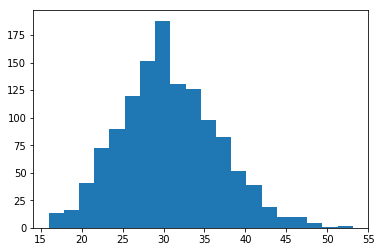

In [102]:
_ = plt.hist(data_prepared.bmi.values, bins = 20)

#### Построим Y(x) для какого-нибудь признака.

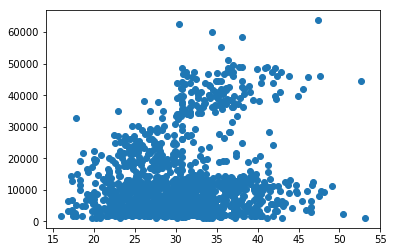

In [101]:
plt.scatter(data_prepared.bmi.values, data_prepared.charges.values)

#### Построим x_1(x_2) для какой-нибудь пары признаков

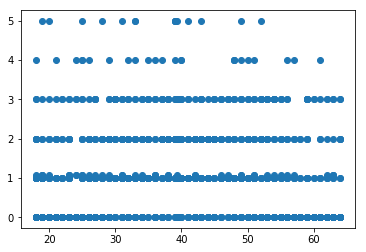

In [113]:
plt.scatter(data_prepared.age.values, data_prepared.children.values)